# Arize Tutorial: Breast Cancer Prediction

Let's get started on using Arize!✨

Arize helps you visualize your model performance, understand drift & data quality issues, and share insights learned from your models. 

In this tutorial, we will be building a model to predict if someone has breast cancer or not. The model predicts a score (how likely is this person to have breast cancer) and based on a threshold, determines the class (True/False). For this model, we will log the score and the class so this model type is `ModelType.SCORE_CATEGORICAL`. We will load the models’s training, validation, and test inferences into Arize. 🚀.

### Running This Notebook
1. Click "Open in playground" to create a copy of this notebook for yourself.
2. Save a copy in Google Drive for yourself.
3. Step through each section below, pressing play on the code blocks to run the cells.
4. In Step 2, use your own Org and API key from your Arize account. 


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Arize-ai/client_python/blob/main/arize/examples/tutorials/Arize_Tutorial_Log_Score_Categorical_Breast_Cancer.ipynb)


## Step 1: Load Data and Build Model

In [ ]:
import numpy as np
import pandas as pd
import uuid
import concurrent.futures as cf
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

def map_proba(y_pred, y_pred_proba):
    """
    Input:
    y_pred (1-dim) and y_pred_proba (n-dim) from sklearn
    Output:
    y_pred_scores (1-dim) np.array for the probability of only the predicted class
    """
    y_pred_scores = [y_pred_proba[i][int(y_pred[i])] for i in range(len(y_pred))]
    return pd.Series(y_pred_scores)

###############################################################################
# 1 Load data and split data
data = datasets.load_breast_cancer()
X, y = datasets.load_breast_cancer(return_X_y=True)

# NOTE: We need to set y.astype(str) since BINARY expected non-integer.
X, y = X.astype(np.float32), y.astype(str)
X, y = pd.DataFrame(X, columns=data['feature_names']), pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

###############################################################################
# 2 Fit a simple logistic regression model
clf = LogisticRegression(max_iter=3000, verbose=False).fit(X_train, y_train)

# 3 Use the model to generate predictions
y_train_pred = clf.predict(X_train)
y_train_pred_proba = clf.predict_proba(X_train)

y_val_pred = clf.predict(X_val)
y_val_pred_proba = clf.predict_proba(X_val)

y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)

# 3.5 Change the format for prediction_scores
y_train_pred_score = map_proba(y_train_pred, y_train_pred_proba)
y_val_pred_score = map_proba(y_val_pred, y_val_pred_proba)
y_test_pred_score = map_proba(y_test_pred, y_test_pred_proba)

print('Step 1 ✅: Load Data & Build Model Done!')

Step 1 ✅: Load Data & Build Model Done!


## Step 2: Import and Setup Arize Client
You can find your `API KEY` and `ORG KEY` at on your [Settings Page](https://app.arize.com/admin). Copy those over to the set-up section. We will also be setting up some metadata to use across all logging. 
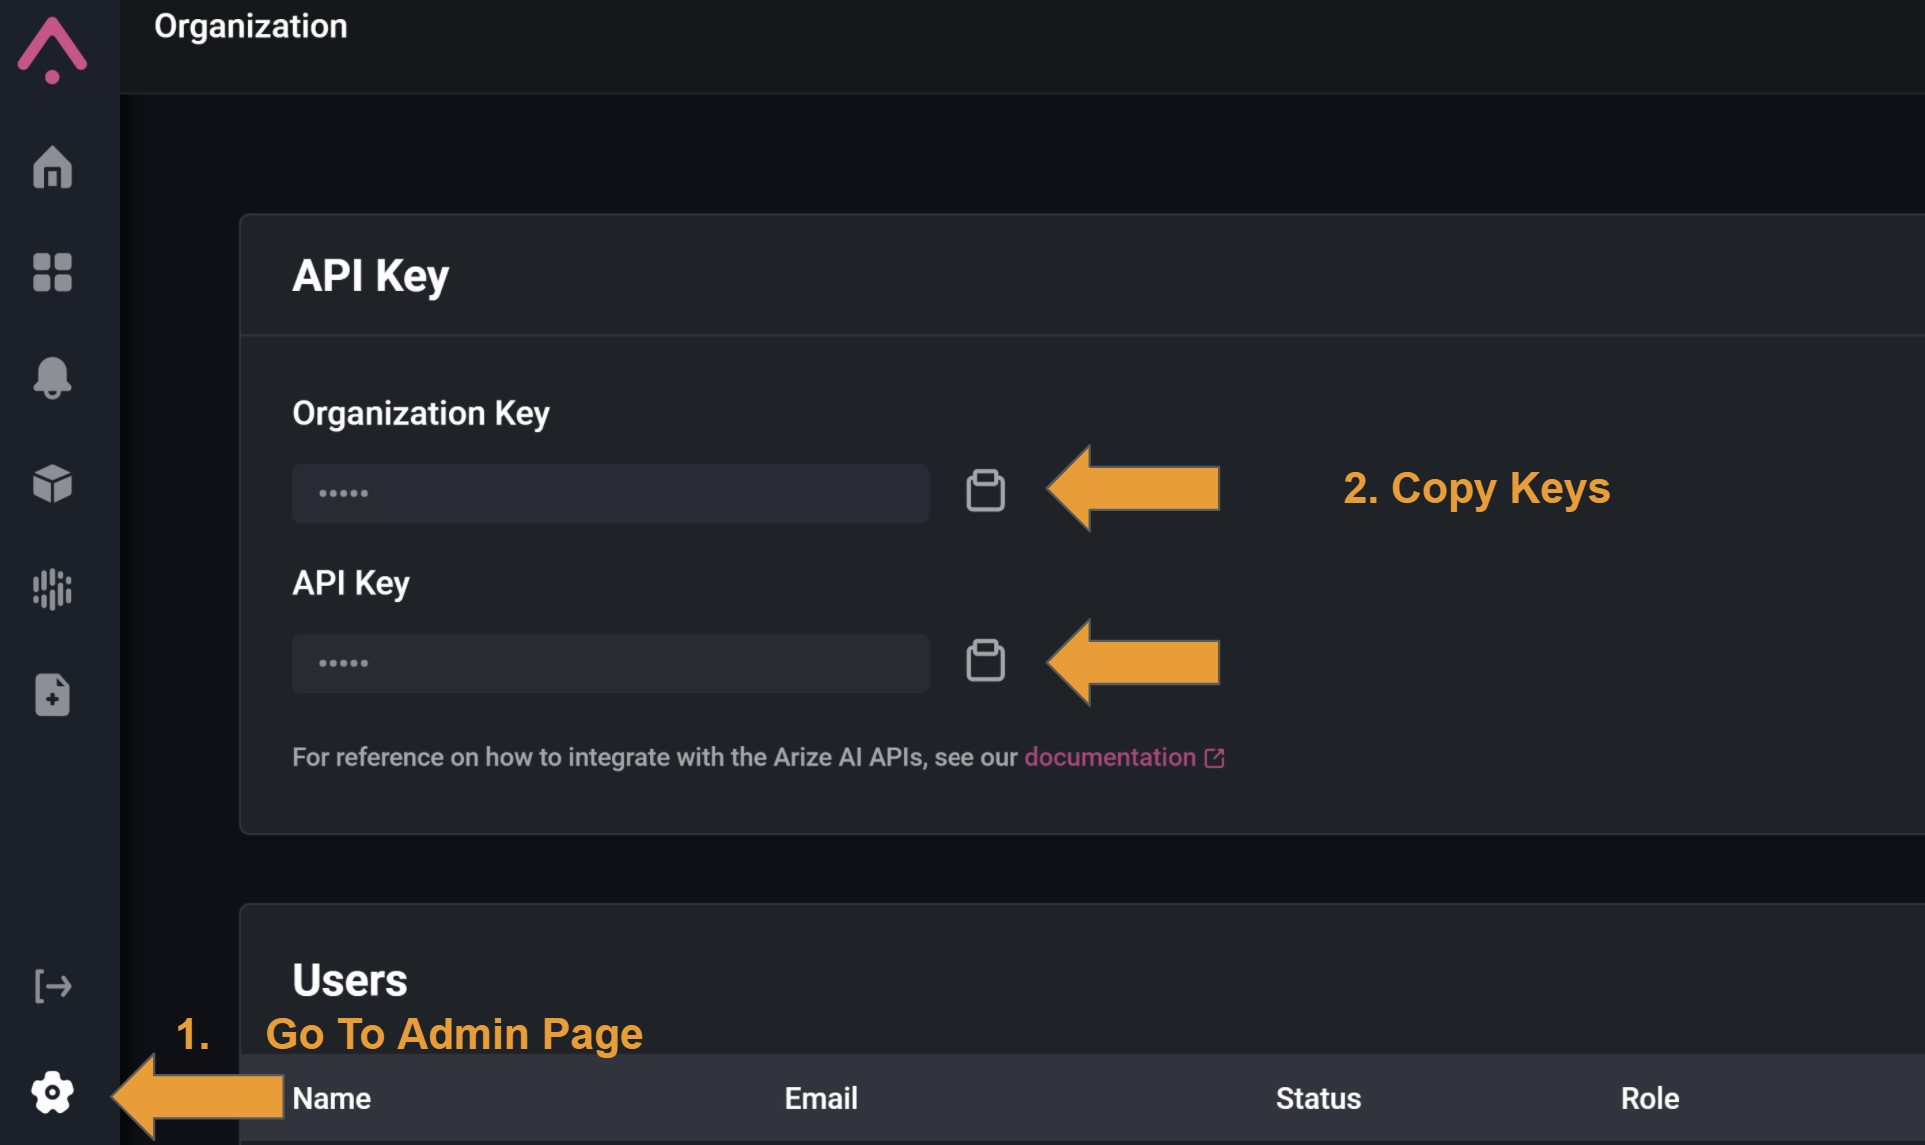

In [ ]:
!pip install arize -q
from arize.api import Client
from arize.types import ModelTypes

ORGANIZATION_KEY = 'YOUR_ORGANIZATION_KEY'
API_KEY = 'YOUR_API_KEY'
arize = Client(organization_key=ORGANIZATION_KEY, api_key=API_KEY)

model_id = 'breast_cancer_score_prediction'
model_version = '1.0'
model_type = ModelTypes.SCORE_CATEGORICAL

print('Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!')

Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!


## Step 3: Log Training Inferences to Arize
First step: Log the training data for your model to Arize! 


In [ ]:
# Logging training
train_prediction_labels = pd.Series(y_train_pred)
train_actual_labels = pd.Series(y_train)
train_feature_df = pd.DataFrame(X_train, columns=data['feature_names'])

train_responses = arize.log_training_records(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type, # this will change depending on your model type
    prediction_labels=train_prediction_labels,
    prediction_scores=y_train_pred_score,
    actual_labels=train_actual_labels,
    features=train_feature_df,
    )
    
## Helper to listen to response code to ensure successful delivery
def arize_responses_helper(responses): 
  for response in cf.as_completed(responses):
    res = response.result()
    if res.status_code != 200:
      print(f'future failed with response code {res.status_code}, {res.text}')

arize_responses_helper(train_responses)

print('Step 3 ✅: If no errors showed up, you have sent Training Inferences!')

Step 3 ✅: If no errors showed up, you have sent Training Inferences!


## Step 4: Log Validation Inferences to Arize
Next Step: Log the validation data. You need to include `batch_id` to separate out different validation sets.

In [ ]:
# Logging validation
val_prediction_labels = pd.Series(y_val_pred)
val_actual_labels = pd.Series(y_val)
val_features_df = pd.DataFrame(X_val, columns=data['feature_names'])

val_responses = arize.log_validation_records(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    batch_id='batch0',
    prediction_labels=val_prediction_labels,
    prediction_scores=y_val_pred_score,
    actual_labels=val_actual_labels,
    features=val_features_df,
    )

arize_responses_helper(val_responses)
print('Step 4 ✅: If no errors showed up, you have sent Validation Inferences!')

Step 4 ✅: If no errors showed up, you have sent Validation Inferences!


# Logging During Production
Next steps simulate production environment

## Step 5: Generating and Formatting SHAP Values
**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model.

For more in-depth usage of the `shap` library, visit [SHAP Core Explainers](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.Explainer.html) and pick an explainer specific to your machine learning model. `shap.Explainer` is the default explainer that will matches model type, but you can specify your own type. For example, you can choose to use for example `shap.TreeExplainer`, but it won't work on models such as `sklearn.LinearModel.LogisticRegression`.

We create this helper function `get_shap_values` to format the data and/or create visualizations for our shap values. We will store our results in a `pd.DataFrame` with matching columns for logging later.

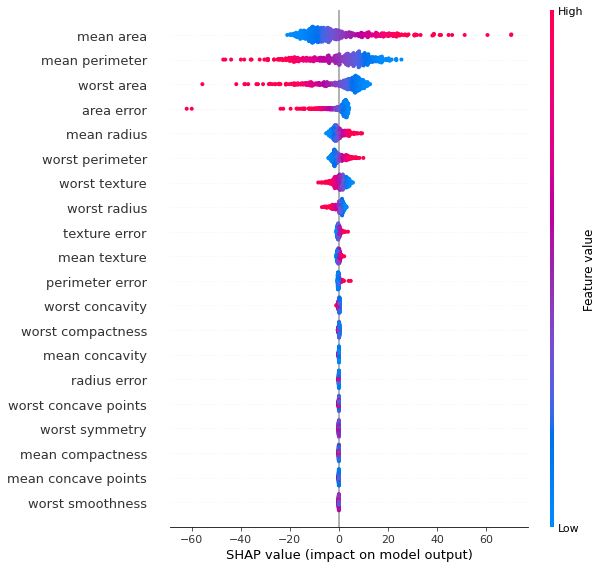

Part 5 ✅: If no errors showed up, you have logged predictions and actuals in bulk!


In [ ]:
!pip install shap
import shap

def get_shap_values(model, X_data, ExplainerType=shap.Explainer, show_graph=False):
    # NOTE: If there are errors, you  need to manually choose which explainer class
    explainer = ExplainerType(model, X_data)
    shap_values = explainer.shap_values(X_data)

    # When not in production, it can be helpful to check graphs for feature explainability
    if show_graph:
        shap.summary_plot(shap_values, X_data, feature_names=data['feature_names'])
    
    # NOTE: Arize API expects a DataFrame of the same shape and column name as the model features.
    return pd.DataFrame(shap_values, columns=data['feature_names'])

shap_values = get_shap_values(clf, X, show_graph=True)
print('Part 5 ✅: If no errors showed up, you have logged predictions and actuals in bulk!')

## Step 6: Production Logging in Bulk to Arize
Note: We will be sending our test data to emulate sending production data. 

1. **prediction_timestamp:** You can directly specify the unix time which the prediction was made by using the optional argument `prediction_timestamp`. This will set the prediction timestamp. It can be a `pd.Series` or `List` of dtype `int` and the same length as the predictions sent. The timestamp at index 1 will be the prediction timestamp at index 1. You can set the prediction timestamp within the last year.

In our example, we used `prediction_timestamp` to simulate predictions over 30 days so you can see it displayed on arize platform right away.

In [ ]:
import numpy as np
import datetime

# bulk_pred_ids_df will be used to uniquely identify these predictions
ids_df = pd.DataFrame([str(uuid.uuid4()) for _ in range(len(y_test))])
y_pred = pd.Series(clf.predict(X_test))
y_score = map_proba(y_pred, clf.predict_proba(X_test))

# For Score Categorical, y_pred shape should be (2, N)
y_pred = pd.Series(zip(y_pred, y_score))

# OPTIONAL: Simulate predictions evenly distributed over 30 days by manually specifying prediction time
current_time = datetime.datetime.now().timestamp()
earlier_time = (datetime.datetime.now() - datetime.timedelta(days=30)).timestamp()
optional_prediction_timestamp = np.linspace(earlier_time, current_time, num=len(y_test_pred))
optional_prediction_timestamp = pd.Series(optional_prediction_timestamp.astype(int))

# Generate SHAP vales 
shap_df = get_shap_values(clf, X_test)

# First we log the predictions and actuals. 
log_bulk_responses = arize.bulk_log(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    prediction_ids=ids_df,
    prediction_labels=y_pred,
    actual_labels=y_test,
    prediction_timestamp=optional_prediction_timestamp,
    shap_values=shap_df,
    features=X_test,
    )

arize_responses_helper(log_bulk_responses)
print('Part 6 ✅: If no errors showed up, you have logged in bulk just now to Arize!')

Part 6 ✅: If no errors showed up, you have logged in bulk just now to Arize!
